In [474]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx


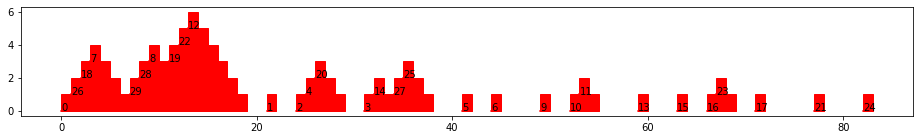

In [475]:
# Using DFS to find the Pre-order and Post-order numbers
def PrePost(G):
    visited = [None for _ in G]
    pretimes = [None for _ in G]
    posttimes = [None for _ in G]
    chartheight = [None for _ in G]
    ctr = [0]
    
    # Explore starting from a root
    def Explore(n, height=0):
        if visited[n]:
            #print("Already visited", n)
            return
        
        ## Visit the node (customize your DFS here)
        
        # Pre visit
        # print('previsit:', n, height, ctr[0])
        chartheight[n] = height
        visited[n] = True
        pretimes[n] = ctr[0]
        ctr[0] += 1
                
        # Visit
        for neighbor in G.adj[n]:
            Explore(neighbor, height+1)

        # Post visit
        # print('postvisit:', n, pretimes[n], ctr[0])
        posttimes[n] = ctr[0]
        ctr[0] += 1

    for n in G:
        Explore(n)
        ctr[0] += 1

    return pretimes, posttimes, chartheight

# Make a drawing of the DFS visit intervals
def draw_dfsintervals(pres, posts, heights, labels=None):
    fig,ax = plt.subplots(1, figsize=(16,2))
    cmap = plt.get_cmap("tab20")
    for n, (pre, post, height) in enumerate(zip(pres, posts, heights)):
        c = cmap(labels[n]) if labels is not None else 'r'
        rect = patches.Rectangle((pre,height),(post-pre),1, color=c)
        ax.add_patch(rect)
        plt.text(pre,height,repr(n))
        plt.plot((pre,post),(height,height), color=c)

G = nx.erdos_renyi_graph(30, 0.05, directed=True)
pres,posts,heights = PrePost(G)
draw_dfsintervals(pres, posts, heights) 

Connected components: [6, 7, 8, 10, 8, 11, 12, 0, 3, 13, 15, 14, 4, 16, 9, 17, 19, 20, 1, 6, 8, 21, 5, 18, 22, 10, 2, 10, 6, 6]
Total number of unique components: 23


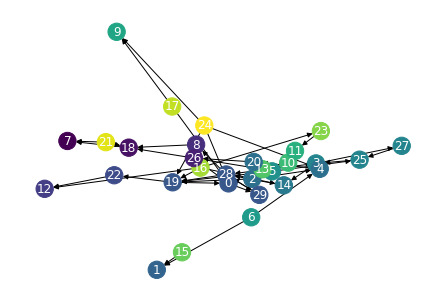

In [477]:
# Ground SCC truth labels (from networkx library)
scclabels = [None for _ in G]
for i,comp in enumerate(nx.strongly_connected_components(G)):
    for n in comp:
        scclabels[n] = i
        
print('Connected components:', scclabels)
print('Total number of unique components:', len(set(scclabels)))
    
nx.draw(G, with_labels=True, font_color='w', node_color=[scclabels[n] for n in G])

Total number of unique components: 23


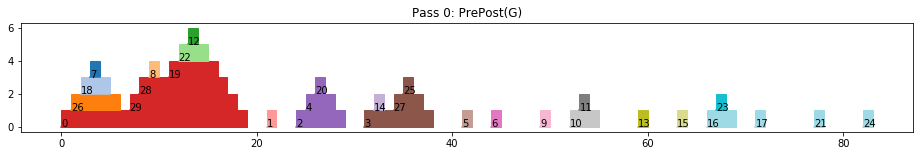

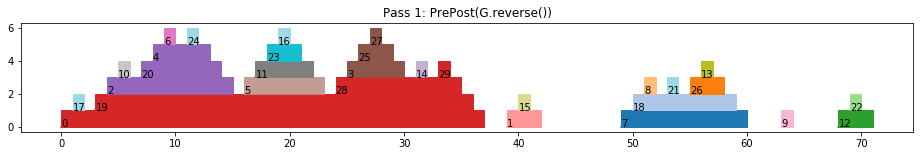

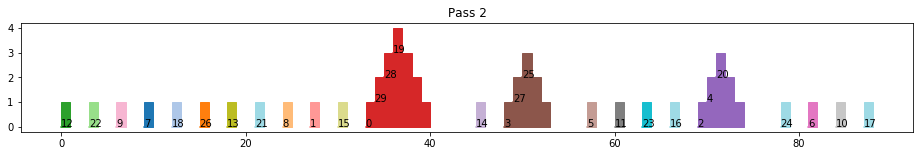

In [483]:
# Kasaraju algorithm: 
#    Relabel the graph based on its visit time, run DFS again

# Pass 1: Find the postorder of the reverse graph

# This use of PrePost is just for illustration, 
# the custom DFS is below
pres,posts,heights = PrePost(G)
draw_dfsintervals(pres, posts, heights, scclabels) 
plt.title('Pass 0: PrePost(G)')
pres,posts,heights = PrePost(G.reverse())
draw_dfsintervals(pres, posts, heights, scclabels) 
plt.title('Pass 1: PrePost(G.reverse())')

# Perform a DFS, storing the nodes in post-visit order
def DFS_in_postorder(G):
    visited = [False for _ in G]
    stack = []
    def Explore(n):
        if visited[n]: return
        visited[n] = True
        for neighb in G.adj[n]:
            Explore(neighb)
        stack.append(n) # In post order sequence
    for n in G:
        Explore(n)
    return stack

stack = DFS_in_postorder(G.reverse())

# Re-order the graph. NetworkX orders the nodes in the order you add them.
# By looping over the post-order stack, we order the nodes correctly
G_re = nx.DiGraph()
for n in stack[::-1]:
    G_re.add_node(n)
for (src,dst) in G.edges:
    G_re.add_edge(src,dst)

# Pass 2: DFS on the reordered graph
pres, posts, heights = PrePost(G_re)
def Find_SCC(G_re):
    visited = {}
    roots = {}
    def Explore(n, root):
        if n in visited: return
        # Visit
        visited[n] = True
        roots[n] = root
        for u in G_re.adj[n]:
            Explore(u, root)
    for n in G_re:
        Explore(n, root=n)
    return roots

# plt.figure()
draw_dfsintervals(pres, posts, heights, scclabels)
plt.title('Pass 2')

# Compare with ground truth
comp2 = Find_SCC(G_re)
print('Total number of unique components:', len(set(comp2.values())))

for u in G:
    for v in G:
        b1 = (comp2[u] == comp2[v])
        b2 = (scclabels[u] == scclabels[v])
        assert b1 == b2